
# Cleaning the training set 
This is slightly different to cleaning the test set because the model which we're using to find false positives and false negatives has already been trained on some of the data in the training set. 

Since we only took a sample of the trainning data to train the model though, we can use the model to predict on the rest of the test set, then clean this portion. We can then make predictions on this remainder of the training set, and re-train a new model on this cleaner training set, hopefully getting better stability through using a cleaner dataset. 

To do this, a list of the samples used during training will be exported along with the model, and we'll drom these samples from the training set to be cleaned. 

Confidence scores:
- 0 UNCHECKED means it hasn't been verified
- 1 DISCARD is something I should throw out, 
- 2 UNSURE is not sure , 
- 3 VERIFIED is definitely an olive sided flycatcher. 
- 4 FOCAL Optionally tag as focal OSFL
- 5 Label needs changing to OSFL 

0 - unchecked

1 - discard

2 - unable to tell

3 - correct label

4 - focal OSFL call

5 - absent tag needs changing to OSFL

This will let me measure performance on a test set which I know only contains verified labels, and optionally mix in on the hard to detect subset which might otherwise get thrown out.




# Label the test set with confidence scores
This part of the notebook 

- takes a test set saved to disk as an AudioFileDataset (or just a pandas dataframe)
- loads each sample with playback option
- takes a user typed label as input
- saves the label in a column of the dataframe titled 'confidence' 
- saves the dataset back to disk



In [54]:
from pathlib import Path
import pandas as pd
import sys
BASE_PATH = Path.cwd().parent.parent
model_save_path = BASE_PATH / "models"
sys.path.append(str(BASE_PATH))
import opensoundscape as opso
from opensoundscape import Audio, Spectrogram
from opensoundscape.preprocess.utils import show_tensor
import torch
from opensoundscape.data_selection import resample
from src.utils import get_hash_from_df


# Load the training data df from disk


In [55]:
data_path = Path.cwd().parent.parent / "data"
train_df = pd.read_pickle(data_path / "interim" / "train_set" / "train_df.pkl")
train_df.drop(columns=["target_absence"], inplace=True)
train_df.value_counts()

target_presence
0.0                45081
1.0                 4211
Name: count, dtype: int64

# Load the indexes of the samples used for previous model training

In [87]:
used_training_samples = pd.read_pickle(model_save_path / "training_indices" / "seed_46_caramel-mousse_1920_absent_960_present_960_focal_2024-03-14.pkl")
overlap = train_df[train_df.index.isin(used_training_samples.index)]
train_df = train_df.drop(index=overlap.index)

# Load the model to make predictions on the training dataframe

In [88]:
model = opso.cnn.load_model(model_save_path / "caramel-mousse_1920_absent_960_present_960_focal_2024-03-14.model")

In [89]:
# Take samples from the full df
present_sample = train_df.loc[train_df["target_presence"] == 1.0].sample(1000, random_state=42)
absent_sample = train_df.loc[train_df["target_presence"] == 0.0].sample(1000, random_state=42)
sample_train_df = train_df.loc

sample_train_df = pd.concat([present_sample, absent_sample])
predictions = model.predict(sample_train_df)

  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/safe_dataset.py:133: UserWarning: There were 1 sample(s) that raised errors and were skipped.
  warnings.warn(msg)


In [90]:
pd.concat([sample_train_df, predictions], axis=1)
sample_train_df

,,,target_presence
file,start_time,end_time,
../../data/raw/recordings/OSFL/recording-292026.mp3,148.5,151.5,1.0
../../data/raw/recordings/OSFL/recording-293854.mp3,16.5,19.5,1.0
../../data/raw/recordings/OSFL/recording-255624.flac,28.5,31.5,1.0
../../data/raw/recordings/OSFL/recording-100257.flac,63.0,66.0,1.0
../../data/raw/recordings/OSFL/recording-292290.mp3,9.0,12.0,1.0
...,...,...,...
../../data/raw/recordings/OSFL/recording-552691.flac,0.0,3.0,0.0
../../data/raw/recordings/OSFL/recording-50049.flac,19.5,22.5,0.0
../../data/raw/recordings/OSFL/recording-556789.flac,0.0,3.0,0.0


In [4]:
data_path = Path.cwd().parent.parent / "data"
df_valid: pd.DataFrame = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_df_verified.pkl")
df_valid_with_preds = pd.read_pickle(data_path / "processed" / "osfl_model_predictions" / "validation_set_predictions_verified.pkl")
balanced_valid_df_with_preds = pd.read_pickle(data_path / "processed" / "osfl_model_predictions" / "balanced_validation_set_predictions_verified.pkl")

In [5]:
# add a column to the dataframe to store the confidence of the label, if it doesn't alredy exist
if 'confidence_cat' not in df_valid.columns:
    df_valid['confidence_cat'] = 0
idx = 0
confidence = 0 # 0 means unchecked. 

In [6]:
df_valid.sample()

,,,target_absence,target_presence,confidence_cat
file,start_time,end_time,,,
../../data/raw/recordings/OSFL/recording-99100.mp3,55.5,58.5,1.0,0.0,0


In [7]:
df_valid_with_preds.sample()

,,,target_presence,confidence_cat,present_pred,loss
file,start_time,end_time,,,,
../../data/raw/recordings/OSFL/recording-538300.flac,153.0,156.0,0.0,0,0.020375,0.020375


In [8]:
def verify_samples(df: pd.DataFrame, target=0.0, loss_sorted=False, autolabel=None):
    # Filter the split dataset further into unverified and present tags.
    unverified = df[df['confidence_cat'] == 0]
    unverified_target_clips = unverified.loc[unverified['target_presence'] == target]
    if len(unverified_target_clips) == 0:
        print("No unverified clips within chosen target class.")
        return df
    
    if loss_sorted:
        # Sort the unverified clips by the loss value.
        unverified_target_clips = unverified_target_clips.sort_values(by='loss', ascending=False)

    # Set the confidence cat to 0 so that any skipped clips or crashes don't get saved as previous confidence.
    confidence = 0

    clip_idx = unverified_target_clips.index[0]
    path, offset, end_time = clip_idx
    duration = end_time - offset
    audio = Audio.from_file(path, offset=offset, duration=duration)
    spec = Spectrogram.from_audio(audio)
    print(f"target = {df.loc[clip_idx].target_presence}, prediction = {df.loc[clip_idx].present_pred} loss = {df.loc[clip_idx].loss}")
    audio.show_widget()
    spec.plot()
    if autolabel:
        input("press enter to autolabel")
        
        user_confidence = autolabel
    else:
        user_confidence = input("enter confidence: 1=Discard, 2=Unsure, 3=Verified, 4=Focal, 5=Re-label-as-OSFL", "6=Re-label-as-absent")

    # save the user input confidence back to the original dataframe.
    df.loc[clip_idx, 'confidence_cat'] = int(user_confidence)
    
    # display the counts
    print(f"added confidence tag {user_confidence} to the dataframe.")
    print(df.loc[df.target_presence == target].confidence_cat.value_counts())

    return df

# Run this line and pass in a dataframe to verify samples. 

target = 1.0, prediction = 0.9985184073448181 loss = 0.0014815926551818848


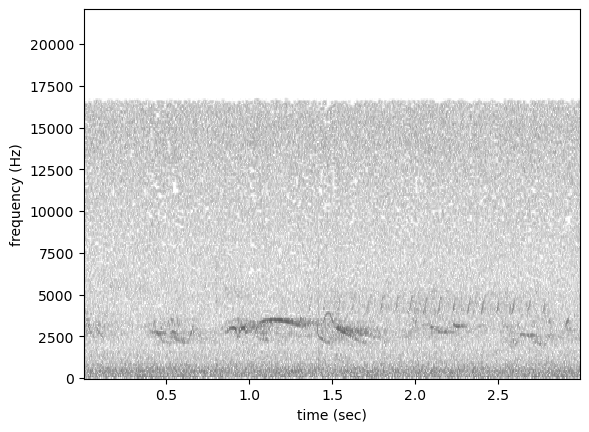

TypeError: Kernel.raw_input() takes from 1 to 2 positional arguments but 3 were given

In [9]:
balanced_valid_df_with_preds = verify_samples(balanced_valid_df_with_preds, target=1.0, loss_sorted=False)

In [ ]:
df_valid.loc[df_valid.target_presence == 1.0]

target_absence  \
file                                               start_time end_time                   
../../data/raw/recordings/OSFL/recording-4478.mp3  30.0       33.0                 0.0   
                                                   66.0       69.0                 0.0   
                                                   121.5      124.5                0.0   
../../data/raw/recordings/OSFL/recording-4504.flac 57.0       60.0                 0.0   
                                                   58.5       61.5                 0.0   
...                                                                                ...   
../../data/raw/recordings/OSFL/recording-768530... 126.0      129.0                0.0   
../../data/raw/recordings/OSFL/recording-813302... 1.5        4.5                  0.0   
../../data/raw/recordings/OSFL/recording-816751... 1.5        4.5                  0.0   
                                                   3.0        6.0                  0.0   
../../data/raw/recordings/OSFL/recording-816752... 40.5       43.5                 0.0   

                                                                        target_presence  \
file                                               start_time end_time                    
../../data/raw/recordings/OSFL/recording-4478.mp3  30.0       33.0                  1.0   
                                                   66.0       69.0                  1.0   
                                                   121.5      124.5                 1.0   
../../data/raw/recordings/OSFL/recording-4504.flac 57.0       60.0                  1.0   
                                                   58.5       61.5                  1.0   
...                                                                                 ...   
../../data/raw/recordings/OSFL/recording-768530... 126.0      129.0                 1.0   
../../data/raw/recordings/OSFL/recording-813302... 1.5        4.5                   1.0   
../../data/raw/recordings/OSFL/recording-816751... 1.5        4.5                   1.0   
                                                   3.0        6.0                   1.0   
../../data/raw/recordings/OSFL/recording-816752... 40.5       43.5                  1.0   

                                                                        confidence_cat  
file                                               start_time end_time                  
../../data/raw/recordings/OSFL/recording-4478.mp3  30.0       33.0                   2  
                                                   66.0       69.0                   1  
                                                   121.5      124.5                  2  
../../data/raw/recordings/OSFL/recording-4504.flac 57.0       60.0                   3  
                                                   58.5       61.5                   3  
...                                                                                ...  
../../data/raw/recordings/OSFL/recording-768530... 126.0      129.0                  2  
../../data/raw/recordings/OSFL/recording-813302... 1.5        4.5                    3  
../../data/raw/recordings/OSFL/recording-816751... 1.5        4.5                    2  
                                                   3.0        6.0                    1  
../../data/raw/recordings/OSFL/recording-816752... 40.5       43.5                   2  

[1043 rows x 3 columns]

# Save the validation work

In [ ]:
balanced_valid_df_with_preds_verified.to_pickle(data_path / "processed" / "osfl_model_predictions" / "balanced_validation_set_predictions_verified.pkl")

In [ ]:
df_valid.to_pickle(data_path / "interim" / "valid_set" / "valid_df_verified.pkl")

In [ ]:
df_valid_with_preds_verified = df_valid_with_preds
df_valid_with_preds_verified.to_pickle(data_path / "processed" / "osfl_model_predictions" / "validation_set_predictions_verified.pkl")

In [ ]:
df_valid_with_preds_verified

target_presence  \
file                                               start_time end_time                    
../../data/raw/recordings/OSFL/recording-4478.mp3  0.0        3.0                   0.0   
                                                   1.5        4.5                   0.0   
                                                   3.0        6.0                   0.0   
                                                   4.5        7.5                   0.0   
                                                   6.0        9.0                   0.0   
...                                                                                 ...   
../../data/raw/recordings/OSFL/recording-816752... 33.0       36.0                  0.0   
                                                   34.5       37.5                  0.0   
                                                   36.0       39.0                  0.0   
                                                   37.5       40.5                  0.0   
                                                   40.5       43.5                  1.0   

                                                                        confidence_cat  \
file                                               start_time end_time                   
../../data/raw/recordings/OSFL/recording-4478.mp3  0.0        3.0                    3   
                                                   1.5        4.5                    3   
                                                   3.0        6.0                    3   
                                                   4.5        7.5                    3   
                                                   6.0        9.0                    3   
...                                                                                ...   
../../data/raw/recordings/OSFL/recording-816752... 33.0       36.0                   0   
                                                   34.5       37.5                   0   
                                                   36.0       39.0                   0   
                                                   37.5       40.5                   0   
                                                   40.5       43.5                   2   

                                                                        present_pred  \
file                                               start_time end_time                 
../../data/raw/recordings/OSFL/recording-4478.mp3  0.0        3.0           0.938833   
                                                   1.5        4.5           0.381346   
                                                   3.0        6.0           0.628573   
                                                   4.5        7.5           0.774142   
                                                   6.0        9.0           0.654895   
...                                                                              ...   
../../data/raw/recordings/OSFL/recording-816752... 33.0       36.0          0.094164   
                                                   34.5       37.5          0.046067   
                                                   36.0       39.0          0.128044   
                                                   37.5       40.5          0.318316   
                                                   40.5       43.5          0.994107   

                                                                            loss  
file                                               start_time end_time            
../../data/raw/recordings/OSFL/recording-4478.mp3  0.0        3.0       0.938833  
                                                   1.5        4.5       0.381346  
                                                   3.0        6.0       0.628573  
                                                   4.5        7.5       0.774142  
                                                   6.0        9.0       0.